In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
import warnings

## Functions List

In [50]:
def linear_f(x, m, b):
    return m*x+b

def fits_f(x_data, y_data, estimate):
    """
    Fit a linear model to the provided data using curve_fit from scipy.optimize.

    Parameters:
    x_data (array-like): Independent variable data.
    y_data (array-like): Dependent variable data.
    estimate (list): Initial guess for the parameters of the linear model [slope, intercept].

    Returns:
    x_fits (array): Independent variable values for the fitted line.
    y_fits (array): Dependent variable values for the fitted line.
    [m, b] (list): Fitted parameters, where m is the slope and b is the intercept of the linear model.
    """
    # Use curve_fit function from scipy.optimize to fit data to a linear function
    popt, pcov = curve_fit(linear_f, x_data, y_data, p0=estimate)
    m, b = popt

    # Generate x and y values for best fit line.
    x_min = x_data.min()
    x_max = x_data.max()
    x_fits = np.linspace(x_min-1*np.abs(x_min), x_max+1*np.abs(x_max), 1000)
    y_fits = linear_f(x_fits, m, b)

    return x_fits, y_fits, [m, b]

def plot_confidence_interval(x_data, y_data, label, color=None):
    """
    Plots a confidence interval for a linear regression model. This is used to calculate the uncertainty in slope
    and y-intercept.

    Args:
        x_data (array-like): Independent variable data.
        y_data (array-like): Dependent variable data.
        label (str): Label for the confidence interval plot.
        color (str): Colour for the confidence interval plot.

    Returns:
        Tuple[float, float]: The uncertainty in the slope (m_unc) and intercept (b_unc) of the regression line.
    """
    # Find the minimum and maximum x values in the data. Then add a constant term to the x_data for regression
    x_min = x_data.min()
    x_max = x_data.max()
    x_with_const = sm.add_constant(x_data)
    
    # Generate a range of x values for the confidence interval
    x_linspace = np.linspace(x_min-3*np.abs(x_min), x_max+3*np.abs(x_max), 500)
    x_linspace_with_const = sm.add_constant(x_linspace)
    
    # Fit a linear regression model to the data
    model_ci = sm.OLS(y_data, x_with_const).fit()
    
    # Get predictions and confidence intervals for the regression. Snake_case "ci" for confidence interval"
    predictions_ci = model_ci.get_prediction(x_linspace_with_const)
    conf_interval = predictions_ci.conf_int()
    lower_bound_ci = conf_interval[:, 0]
    upper_bound_ci = conf_interval[:, 1]
    
    # Plot the confidence interval
    plt.fill_between(x_linspace, lower_bound_ci, upper_bound_ci, color=color, alpha=0.1, label=label)
    
    # Calculate uncertainty in slope and intercept. Snake_case "lb" for lower bound; "ub" for upper bound.
    # These are points on the confidence intervals used to calculate uncertainty bounds.
    point1 = [x_linspace[0], lower_bound_ci[0]]
    point2 = [x_linspace[-1], upper_bound_ci[-1]]
    point3 = [x_linspace[0], upper_bound_ci[0]]
    point4 = [x_linspace[-1], lower_bound_ci[-1]]
    
    slope_lb = (lower_bound_ci[-1] - upper_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_ub = (upper_bound_ci[-1] - lower_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_uncertainty = np.abs(slope_lb - slope_ub) / 2
    
    intercept_lb = point2[1] - slope_ub * point2[0]
    intercept_ub = point4[1] - slope_lb * point4[0]
    intercept_uncertainty = np.abs(intercept_lb - intercept_ub) / 2
    
    return slope_uncertainty, intercept_uncertainty

def z_to_d(z, z_err=0, units='Mpc'):
    """Converts redshift (z) to distance (d) in various units.
    Args:
        z (float): Redshift value.
        z_err (float): Error in redshift value (default is 0).
        units (str): Unit for the output distance ('ly', 'km', or 'Mpc', default is 'Mpc').

    Returns:
        tuple: A tuple containing the converted distance (d) and its error (d_err) in the specified units.
    """
    c = 299792458 * 1e-3  # Speed of light in km/s
    H_0 = 68.3  # Hubble's Constant in km/s/Mpc
    H_0_err = 1.5  # Hubble's Constant error in km/s/Mpc
    
    # Used when converting Mpc to other units
    conversion_factors = {
        'ly': 3.262e+6,
        'km': 3.086e+22,
        'Mpc': 1.0  
    }
    
    if units not in conversion_factors:
        raise ValueError("Not a valid unit. Try any of 'Mpc', 'ly', or 'km'.")
    
    conversion_factor = conversion_factors[units]
    d = c * z / H_0 * conversion_factor
    d_err = np.sqrt((z_err * c / H_0 * conversion_factor) ** 2 + (H_0_err * c * z / H_0 ** 2 * conversion_factor) ** 2)  # Errors of z and H_0 are treated independently.
    
    return d, d_err

def apply_custom_style(title, xlabel, ylabel, style=1):
    """
    Apply a custom style to a Matplotlib plot.
    """
    if style == 1:
        # Set the ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.title(title, fontsize=16)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.6) # major gridlines
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1) # minor gridlines
    else:
        warnings.warn(f"Style = {style} is not an option. Choosing default style = 1.", UserWarning)
        style = 1

def plot_features(x_data, y_data, group_col=None, best_fit=True, cinterval=True, residuals=True):
    """
    Generate scatter plots with colored data points and best fit lines for unique values in a mask column.
    Features include
        - scatter plot of x_data and y_data
        - line of best fit
        - 95% confidence interval of linear regression.

    Parameters:
    - x_data (array-like): X-axis data.
    - y_data (array-like): Y-axis data.
    - mask_col (array-like, optional): Column to group data by unique values.
    - best_fit (boolean, optional): True to display best fit line. False otherwise. Defaults True.
    - cinterval (boolean, optional): True to display 95% confidence interval. False otherwise. Defaults True.
    - cinterval (boolean, optional): True to return residuals of best fit line. False otherwise. Defaults True.
    """
    values = group_col.unique()
    colors = ['b', 'r', 'g']
    residuals_dict = {}
    
    for i, value in enumerate(values):
        mask = group_col == value # This mask is used to filter out certain data to create groups.
        count = sum(mask)
        plt.scatter(x_data[mask], y_data[mask], s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f'{value} (N={count})')
        
        # Plot the confidence interval
        if cinterval == True:
            # Fit the data for TYPE == 0 and plot the confidence interval
            m_unc, b_unc = plot_confidence_interval(x_data[mask], y_data[mask], f'95% Confidence Interval ({value})', color=colors[i])
        
        # Fit the data and plot the best fit line
        if best_fit == True:
            x_fit, y_fit, opt = fits_f(x_data[mask], y_data[mask], [1, 4])
            plt.plot(x_fit, y_fit, label=f'Line of Best Fit ({value}):\n $y=({opt[0]:.2f}\pm{m_unc:.2f})x+({opt[1]:.2f}\pm{b_unc:.2f})$', color=colors[i], linestyle='--')
        
        if residuals == True:
            residual_y = y_data[mask] - linear_f(x_data[mask], opt[0], opt[1])
            residual_x = x_data[mask]
            residuals_dict[value] = [residual_x, residual_y]
    
    return residuals_dict

def plot_residuals(residuals, xlabel, ylabel, filename):
    """
    Display residual plots using a dictionary of residuals.

    Parameters:
    - residuals (dict): A dictionary where keys represent plot labels, and values are 2D arrays of residual data.
    - xlabel (str): Label for the x-axis of the residual plots.
    - ylabel (str): Label for the y-axis of the residual plots.
    - filename (str): File to save plot to (without file extension)
    """
    colors = ['b', 'r', 'g']
    num_plots = len(residuals)
    
    # Iterate through the residuals dictionary
    for i, (key, values) in enumerate(residuals.items()):
        residuals_x = values[0]
        residuals_y = values[1]
        
        # Calculate residual statistics
        mean_res = np.mean(residuals_y)
        max_res = np.max(residuals_y)
        min_res = np.min(residuals_y)
        
        # Create a subplot for each set of residuals
        plt.subplot(num_plots, 1, i+1)  # Create the top subplot
        plt.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
        plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
        plt.title(f'Residual Plot for ({key})', fontsize=14)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel('Residuals of ' + ylabel, fontsize=9)
        
        # Add residual statistics to the legend
        plt.legend([f"Mean: {mean_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"],
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12, handlelength=0)
        
        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.6) # major gridlines
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1) # minor gridlines
               
    plt.tight_layout()  # Ensure proper spacing between subplots
    
    plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
    plt.show()

## Query Copy

##### Added Effective Radius r_e from t1.

SELECT 
    t1.CATID, t1.ellip, t1.z_spec, t1.Mstar, t1.g_i, t1.M_r, t1.r_e
    t2.CUBEID, t2.CUBEIDPUB, t2.SIGMA_3_ARCSECOND, t2.SIGMA_3_ARCSECOND_ERR, 
    t3.TYPE, 
    t4.Age_3_ARCSECOND, t4.Age_3_ARCSECOND_ERR, 
    t5.SFR_3_ARCSECOND, t5.SFR_3_ARCSECOND_ERR,
    t6.WARNSKER, t6.WARNZ
FROM 
    sami_dr3.InputCatGAMADR3 as t1
JOIN 
    sami_dr3.samiDR3Stelkin as t2 ON t2.CATID = t1.CATID
JOIN 
    sami_dr3.VisualMorphologyDR3 as t3 ON t3.CATID = t1.CATID
JOIN 
    sami_dr3.SSPAperturesDR3 as t4 ON t4.CATID = t1.CATID # THIS DUPLICATES SO MUCH DATA FOR SOME REASON
JOIN 
    sami_dr3.EmissionLine1compDR3 as t5 ON t5.CATID = t1.CATID
JOIN 
    sami_dr3.CubeObs as t6 ON t6.CATID = t1.CATID
WHERE 
    t3.TYPE IN (0, 0.5);

In [44]:
df = pd.read_csv("Query.csv")
df = df[pd.notna(df['SIGMA_3_ARCSECOND']) & pd.notna(df['M_r'])]
df['CATID'].unique()

array([  7289,   7839,   7969,   8487,   8488,   8865,  15165,  15481,
        16022,  16526,  17390,  22582,  23082,  23265,  23341,  30469,
        30615,  30847,  31623,  32196,  39057,  40445,  40491,  41059,
        41180,  41274,  47152,  47254,  48470,  48548,  54202,  54270,
        54500,  54921,  55143,  56181,  62239,  62244,  65408,  65410,
        70022,  70114,  70640,  70670,  70802,  70808,  71178,  78530,
        79706,  79733,  79750,  79810,  79866,  84106,  84209,  84734,
        85205,  85559,  85667,  91545,  91568,  91689,  91691,  91697,
        91963,  91988,  92773,  93803,  93807,  97915,  98880,  99428,
       106549, 107137, 107528, 136238, 136605, 136842, 136871, 137037,
       137838, 143291, 143735, 177969, 184042, 184046, 184648, 185365,
       185567, 185914, 202480, 203833, 204832, 204877, 205211, 208652,
       209185, 209680, 210467, 214211, 214250, 215289, 216184, 220112,
       220218, 220437, 220465, 227266, 227617, 228708, 229164, 230455,
      

In [32]:
d, d_err = z_to_d(df['z_spec'], units='Mpc')
df['D'] = d
df['D_err'] = d_err
df

,CATID,ellip,z_spec,Mstar,g_i,M_r,CUBEID,CUBEIDPUB,SIGMA_3_ARCSECOND,SIGMA_3_ARCSECOND_ERR,TYPE,SFR_3_ARCSECOND,SFR_3_ARCSECOND_ERR,WARNSKER,WARNZ,D,D_err
0,7289,0.2661,0.08682,11.12,1.32,-22.370001,7289_blue_red_7_Y18SAR3_P002_12T122_2018_05_07...,7289_A,224.604782,1.979910,0.5,0.046442,NaN,0,0,381.083175,8.369323
1,7715,0.2308,0.07798,10.99,1.29,-22.059999,7715_blue_red_7_Y14SAR4_P002_12T064_2014_05_23...,7715_A,NaN,NaN,0.5,0.041655,0.017708,1,0,342.281331,7.517160
2,7839,0.2481,0.04749,11.05,1.28,-22.100000,7839_blue_red_7_Y16SAR4_P002_12T101_2017_04_19...,7839_A,223.141388,1.534257,0.5,0.114935,0.041057,0,0,208.450132,4.577968
3,7969,0.1772,0.08554,11.02,1.32,-22.120001,7969_blue_red_7_Y16SAR4_P002_12T101_2017_04_19...,7969_A,258.039948,2.063124,0.5,0.010361,NaN,0,0,375.464800,8.245933
4,8487,0.2416,0.02024,10.59,1.13,-21.129999,8487_blue_red_7_Y15SAR3_P001_12T084_2015_04_14...,8487_A,220.887817,1.786638,0.5,0.006967,NaN,0,0,88.840398,1.951107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,622350,0.0825,0.08733,11.10,1.33,-22.290001,622350_blue_red_7_Y15SAR2_P001_09T107_2016_02_...,622350_A,205.687897,2.124295,0.0,0.008742,NaN,0,0,383.321741,8.418486
543,623017,0.0801,0.06996,10.85,1.28,-21.709999,623017_blue_red_9_Y17SAR2_P002_09T129_2018_02_...,623017_A,162.377853,1.974103,0.5,0.038560,0.021886,0,0,307.078767,6.744043
544,663440,0.1309,0.02307,9.95,1.02,-19.790001,663440_blue_red_7_Y14SAR2_P006_09T073_2016_03_...,663440_A,80.725708,0.963817,0.5,0.034339,0.003796,0,0,101.262255,2.223915
545,3628218,NaN,0.08905,10.96,1.14,NaN,3628218_blue_red_7_Y16SAR2_P002_09T118_2016_03...,3628218_A,164.405731,1.444420,0.5,0.563812,0.052473,0,0,390.871436,8.584292


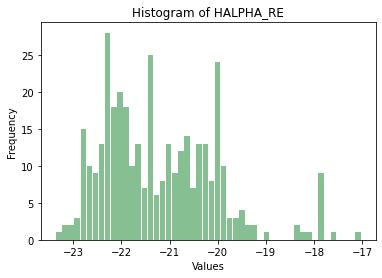

In [11]:
import matplotlib.pyplot as plt

# Assuming that 'df_ell' is your DataFrame and 'HALPHA_RE' is the column for which you want to plot histogram
df['M_r'].hist(bins=50, grid=False, color='#86bf91', rwidth=0.9)

plt.title('Histogram of HALPHA_RE')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

## Data Cleaning
- Only take values with error <5%?
- Delete duplicate rows

- Find a way to estimate Mstar to get more data. Compare the accuracy. 

In [12]:
def Mstar_approximator_f(g_i, Mi, k =0.4):
    Mstar_approx = 1.15 + 0.70*g_i - k*Mi
    return Mstar_approx

## Faber-Jackson Relation

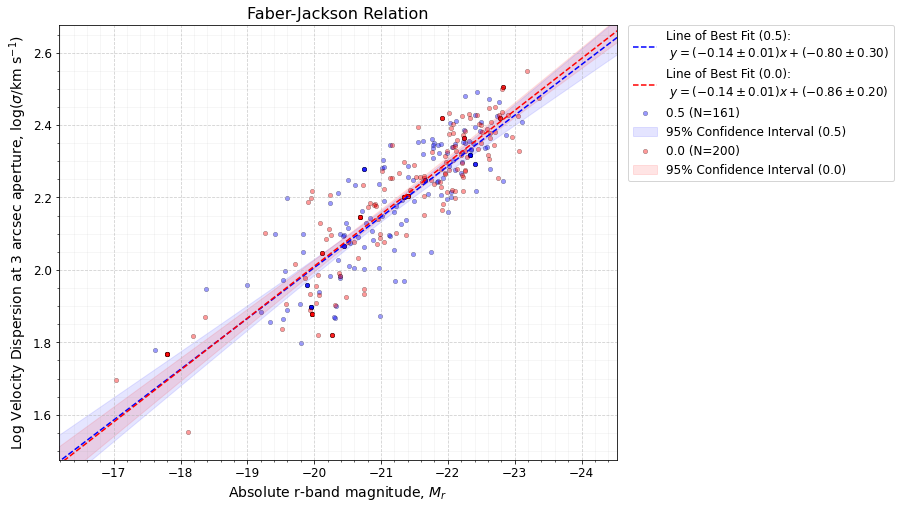

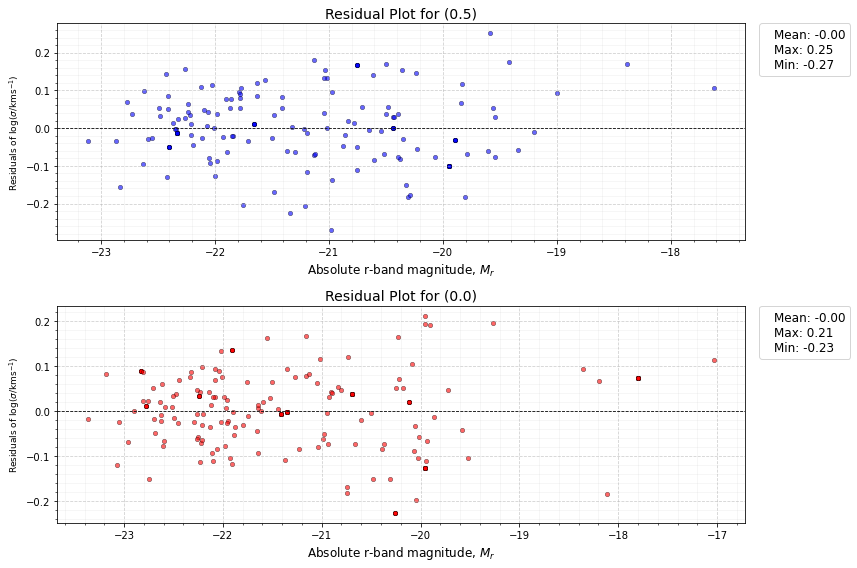

In [51]:
# Define constants
y_data = np.log10(df['SIGMA_3_ARCSECOND'])
x_data = df['M_r']
title = 'Faber-Jackson Relation'
xlabel = 'Absolute r-band magnitude, $M_r$'
ylabel = 'Log Velocity Dispersion at 3 arcsec aperture, $\log(\sigma / \mathrm{km\ s}^{-1})$'

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the features: data points, line of best fit, and 95% confidence interval grouping by df['TYPE']
residuals = plot_features(x_data, y_data, df['TYPE'], residuals=True)

# Set the custom style
apply_custom_style(title, xlabel, ylabel)   

# Set the limits
y_min = min(y_data)
y_max = max(y_data)
x_min = min(x_data)
x_max = max(x_data)
plt.xlim(x_min-0.05*np.abs(x_min), x_max+0.05*np.abs(x_max))
plt.ylim(y_min-0.05*np.abs(y_min), y_max+0.05*np.abs(y_max))

# Invert x-axis
plt.gca().invert_xaxis()

# Save and display the plot
plt.savefig('faber_jackson_relation.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a new figure for residuals
plt.figure(figsize=(12, 8))

# Plot residuals.
plot_residuals(residuals, xlabel, ylabel=r"log($\sigma / \mathrm{km s}^{-1}$)", filename='faber_jackson_residuals')


## MASS v DISPERSION

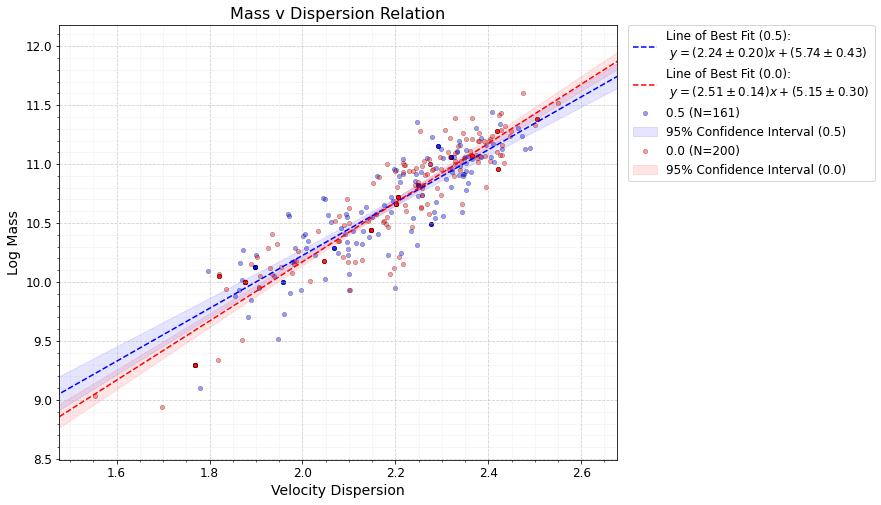

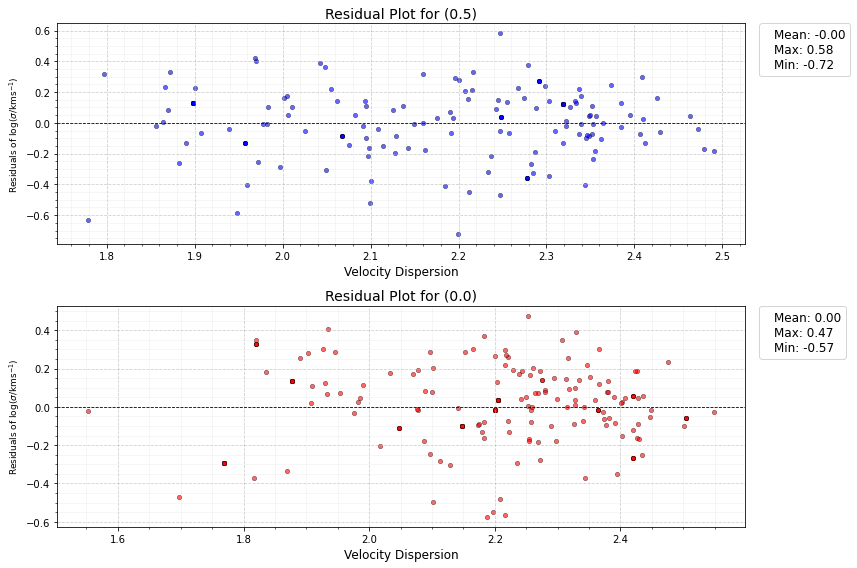

In [52]:
# Define constants
y_data = df['Mstar']
x_data = np.log10(df['SIGMA_3_ARCSECOND'])
title = 'Mass v Dispersion Relation'
xlabel = 'Velocity Dispersion'
ylabel = 'Log Mass'

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the features: data points, line of best fit, and 95% confidence interval grouping by df['TYPE']
residuals = plot_features(x_data, y_data, df['TYPE'], residuals=True)

# Set the custom style
apply_custom_style(title, xlabel, ylabel)   

# Set the limits
y_min = min(y_data)
y_max = max(y_data)
x_min = min(x_data)
x_max = max(x_data)
plt.xlim(x_min-0.05*np.abs(x_min), x_max+0.05*np.abs(x_max))
plt.ylim(y_min-0.05*np.abs(y_min), y_max+0.05*np.abs(y_max))

# Save and display the plot
plt.savefig('mass_disp_relation.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a new figure for residuals
plt.figure(figsize=(12, 8))

# Plot residuals.
plot_residuals(residuals, xlabel, ylabel=r"log($\sigma / \mathrm{km s}^{-1}$)", filename='mass_disp_residuals')


## Distance (z) vs. Velocity Dispersion

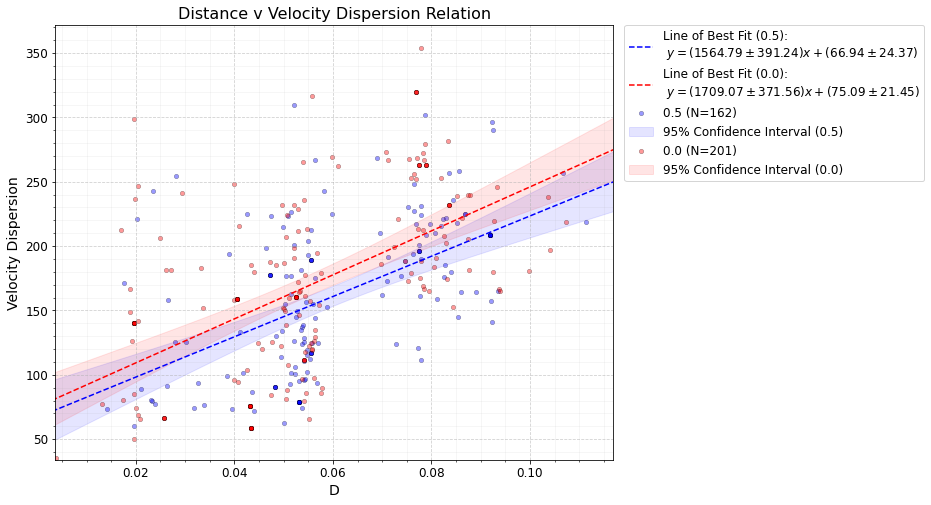

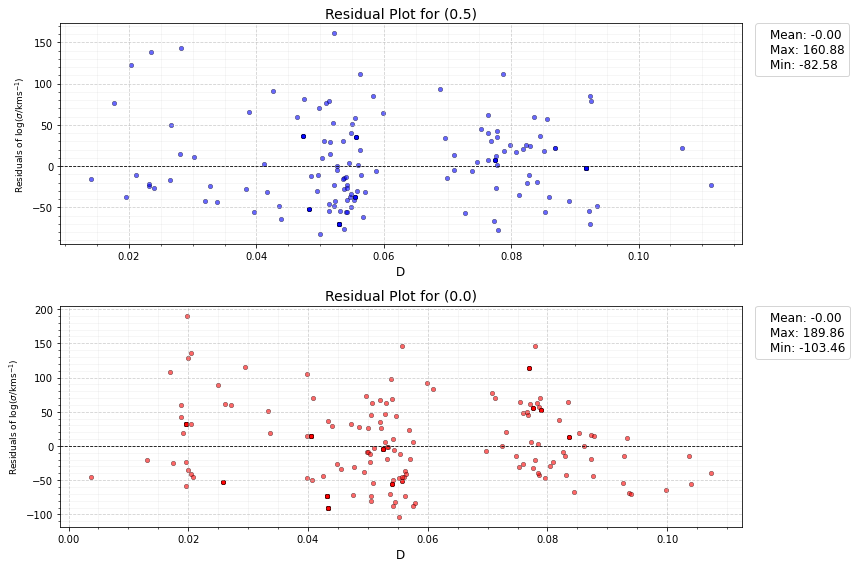

In [54]:
# Define constants
df = pd.read_csv("Query.csv")
y_data = df['SIGMA_3_ARCSECOND']
x_data = df['z_spec']
title = 'Distance v Velocity Dispersion Relation'
xlabel = 'D'
ylabel = 'Velocity Dispersion'
df = df[pd.notna(x_data) & pd.notna(y_data)]
y_data = df['SIGMA_3_ARCSECOND']
x_data = df['z_spec']

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the features: data points, line of best fit, and 95% confidence interval grouping by df['TYPE']
residuals = plot_features(x_data, y_data, df['TYPE'], residuals=True)

# Set the custom style
apply_custom_style(title, xlabel, ylabel)   

# Set the limits
y_min = min(y_data)
y_max = max(y_data)
x_min = min(x_data)
x_max = max(x_data)
plt.xlim(x_min-0.05*np.abs(x_min), x_max+0.05*np.abs(x_max))
plt.ylim(y_min-0.05*np.abs(y_min), y_max+0.05*np.abs(y_max))

# Save and display the plot
plt.savefig('mass_disp_relation.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a new figure for residuals
plt.figure(figsize=(12, 8))

# Plot residuals.
plot_residuals(residuals, xlabel, ylabel=r"log($\sigma / \mathrm{km s}^{-1}$)", filename='mass_disp_residuals')


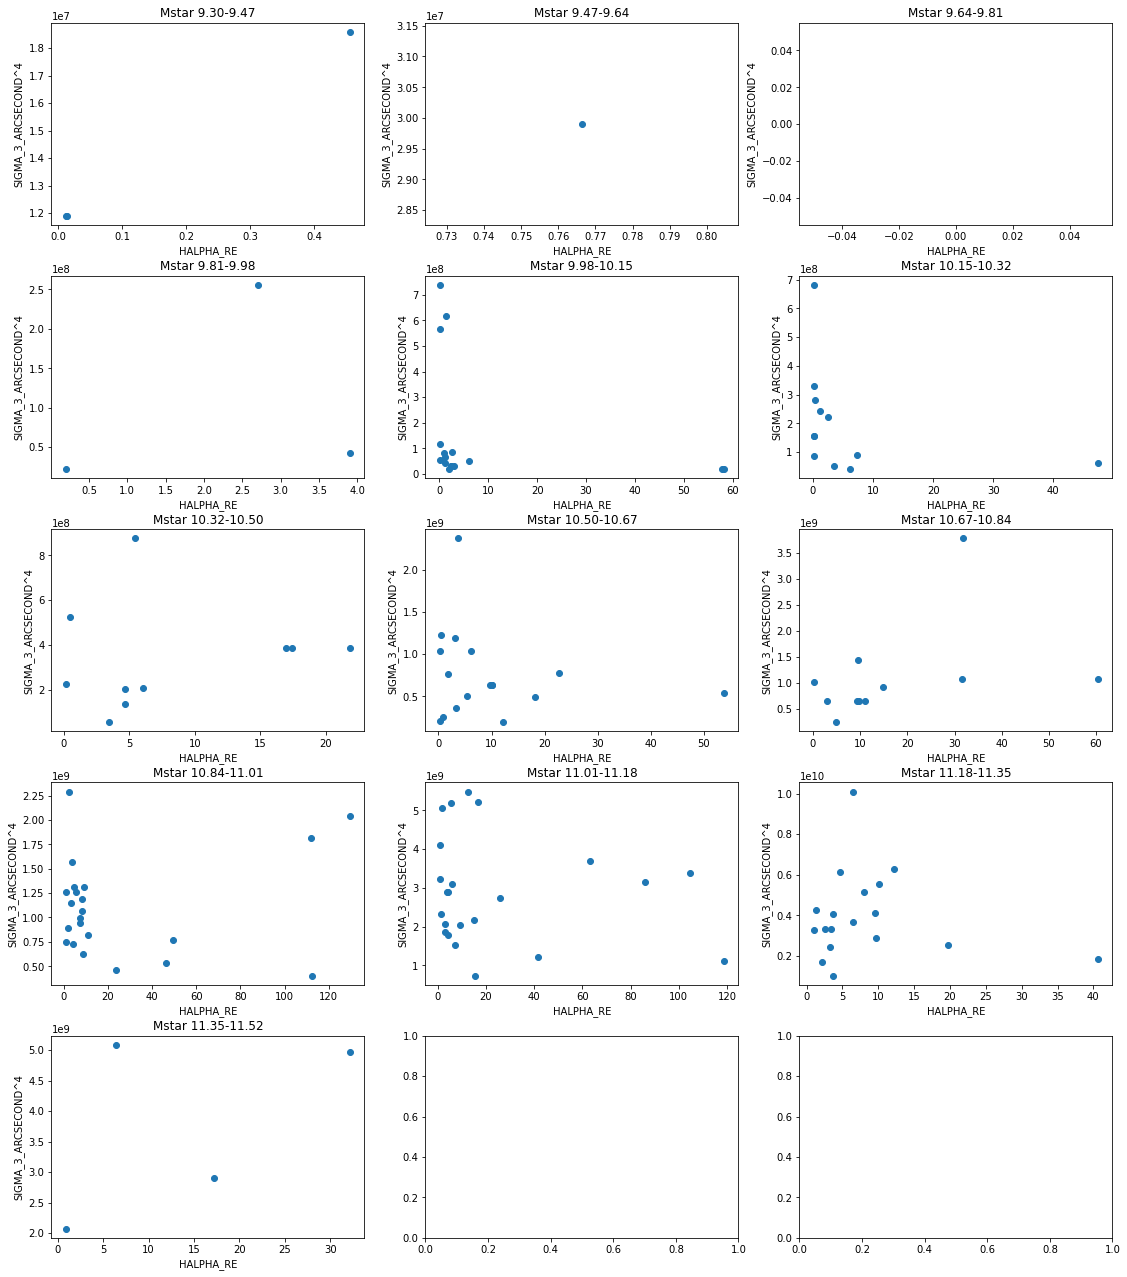

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the Mstar ranges
min_mass = df_ell['Mstar'].min()
max_mass = df_ell['Mstar'].max()
step = (max_mass - min_mass) / 13
mstar_ranges = np.arange(min_mass, max_mass + 0.001, step)

# Create subplots with a larger figure size and adjusted tight_layout
fig, axes = plt.subplots(5, 3, figsize=(16, 18))  # Increase the height (second argument)
fig.tight_layout(pad=3.0)  # Reduce the padding between subplots

for i in range(len(mstar_ranges) - 1):
    mstar_min, mstar_max = mstar_ranges[i], mstar_ranges[i + 1]

    # Filter data for the current Mstar range
    filtered_data = df_ell[(df_ell['Mstar'] >= mstar_min) & (df_ell['Mstar'] < mstar_max)]

    # Scatter plot
    ax = axes[i // 3, i % 3]
    ax.scatter(filtered_data['HALPHA_RE'], filtered_data['SIGMA_3_ARCSECOND'] ** 4)
    ax.set_title(f'Mstar {mstar_min:.2f}-{mstar_max:.2f}')  # Adjusted formatting
    ax.set_xlabel('HALPHA_RE')
    ax.set_ylabel('SIGMA_3_ARCSECOND^4')

# Show the plots
plt.show()


In [13]:
df2

,ID,[Fe/H],wt,E(B-V),V_HB,(m-M)V,V_t,"M_V,t",U-B,B-V,V-R,V-I,spt,ellip
0,NGC 104,-0.72,10,0.04,14.06,13.37,3.95,-9.42,0.37,0.88,0.53,1.14,G4,0.09
1,NGC 288,-1.32,3,0.03,15.44,14.84,8.09,-6.75,0.08,0.65,0.45,0.94,,
2,NGC 362,-1.26,5,0.05,15.44,14.83,6.4,-8.43,0.16,0.77,0.49,1.01,F9,0.01
3,Whiting 1,-0.7,1,0.03,18.18,17.49,15.03,-2.46,,,,,,
4,NGC 1261,-1.27,3,0.01,16.70,16.09,8.29,-7.8,0.13,0.72,0.45,0.93,F7,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,NGC 7089,-1.65,5,0.06,16.05,15.50,6.47,-9.03,0.09,0.66,0.46,0.92,F4,0.11
153,NGC 7099,-2.27,4,0.03,15.10,14.64,7.19,-7.45,0.03,0.6,0.41,0.86,F3,0.01
154,Pal 12,-0.85,6,0.02,17.13,16.46,11.99,-4.47,0.34,1.07,,,,
155,Pal 13,-1.88,2,0.05,17.75,17.23,13.47,-3.76,0.11,0.76,,,,


# Tutorial Week 1

28    -10.26
133    -9.98
95     -9.63
0      -9.42
12     -9.42
       ...  
146    -5.61
37     -5.17
45     -4.80
105    -4.75
155    -3.76
Name: Lum, Length: 62, dtype: float64

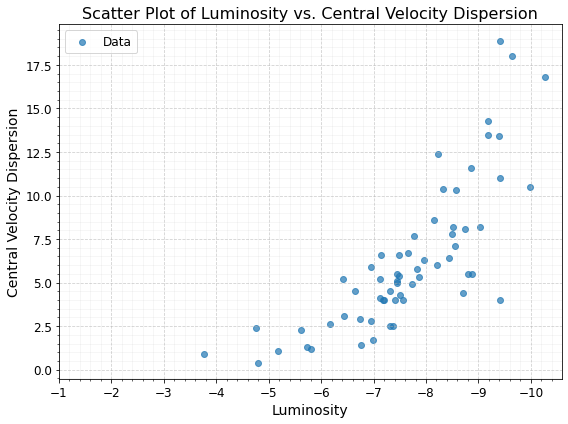

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data from CSV files
df2 = pd.read_csv("HarrisPartII.csv")
df3 = pd.read_csv("HarrisPartIII.csv")

# Create a new DataFrame combining selected columns
dfnew = pd.DataFrame({
    'ID2': df2['ID'],
    'ID3': df3['ID'],
    'Lum': df2['M_V,t'],
    'V_disp': df3['sig_v']
})

# Remove rows with empty 'Lum' values and NaN 'V_disp' values
dfnew = dfnew[~(dfnew['Lum'] == '     ')]
dfnew = dfnew[~dfnew['V_disp'].isna()]
dfnew['Lum'] = pd.to_numeric(dfnew['Lum'], errors='coerce')

# Sort the DataFrame by 'Lum' column in ascending order
#dfnew = dfnew.sort_values(by='Lum', ascending=True)

v_disp = dfnew['V_disp']
lum = dfnew['Lum']

# Create a scatter plot with custom styling
plt.figure(figsize=(8, 6))
plt.scatter(lum, v_disp, marker='o', alpha=0.7, label='Data')

# Customize the x-axis ticks to be integers
plt.xticks(np.arange(-10, 0, 1), fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)
apply_custom_style('Scatter Plot of Luminosity vs. Central Velocity Dispersion', 'Luminosity', 'Central Velocity Dispersion')

# Invert x-axis
plt.gca().invert_xaxis()

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
